### 0. Installation

In [ ]:
!pip3 install bitsandbytes peft trl matplotlib
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu124  #  CUDA 12.4 =cu124, change it to your cuda version

!nvidia-smi # check your cuda version


### 1. Train

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

import warnings
warnings.filterwarnings("ignore")

c:\Users\User\Desktop\MyFinMarkdown-main\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from datasets import load_dataset

# 10 sample to train
ds_full = load_dataset("jinkhye/MyFinMarkdown-sample", split="train[:10]")
# 8/2
tmp = ds_full.train_test_split(test_size=0.2, seed=42)
train_ds = tmp["train"]      # 8
rest_ds  = tmp["test"]       # 2
# 1/1 (from 2)
tmp2 = rest_ds.train_test_split(test_size=0.5, seed=42)
val_ds   = tmp2["train"]     # 1
test_ds  = tmp2["test"]      # 1

print(len(train_ds), len(val_ds), len(test_ds))  # 8 1 1


8 1 1


In [3]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060


In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

bnb = BitsAndBytesConfig(
  load_in_4bit=True, bnb_4bit_use_double_quant=True,
  bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16,
)

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(
  model_id, quantization_config=bnb, device_map="auto", torch_dtype=torch.float16
)

model.config.use_cache = False
model.gradient_checkpointing_enable()
model.config.attn_implementation = "sdpa"

for n, p in model.named_parameters():
    if "vision_tower" in n or "multi_modal_projector" in n:
        p.requires_grad_(False)

model = prepare_model_for_kbit_training(
    model,
    use_gradient_checkpointing=True
)

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:48<00:00, 24.39s/it]


In [5]:
from peft import LoraConfig, get_peft_model
lora = LoraConfig(
  r=4, lora_alpha=16, lora_dropout=0.05, bias="none",
  target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
  task_type="CAUSAL_LM",
)
print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, lora)
peft_model.print_trainable_parameters()


Before adapter parameters: 3754622976
trainable params: 9,288,192 || all params: 3,763,911,168 || trainable%: 0.2468


In [6]:
from PIL import Image
from torch.utils.data import DataLoader
from trl import SFTTrainer
from transformers import TrainingArguments

if processor.tokenizer.pad_token is None:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


In [ ]:
def collate(features):
    import torch
    from PIL import Image

    prompt_texts, target_texts, images = [], [], []

    for f in features:
        msgs = f["messages"]

        sys_text = None
        for m in msgs:
            if m.get("role") == "system":
                if isinstance(m.get("content"), list):
                    sys_text = "\n".join([c.get("text", "") for c in m["content"] if c.get("type") == "text"])
                else:
                    sys_text = str(m.get("content", ""))
                break
        if sys_text is None:
            sys_text = "You are a PDF-to-Markdown converter specialized in financial tables. Output ONLY clean Markdown."

        user_text = ""
        for m in msgs:
            if m.get("role") == "user":
                if isinstance(m.get("content"), list):
                    user_text = "\n".join([c.get("text", "") for c in m["content"] if c.get("type") == "text"])
                else:
                    user_text = str(m.get("content", ""))
                break  

        asst_text = ""
        for m in reversed(msgs):
            if m.get("role") == "assistant":
                if isinstance(m.get("content"), list):
                    asst_text = "\n".join([c.get("text", "") for c in m["content"] if c.get("type") == "text"])
                else:
                    asst_text = str(m.get("content", ""))
                break
        target_texts.append(asst_text)

        mm_msgs = [
            {"role": "system", "content": [{"type": "text", "text": sys_text}]},
            {"role": "user",   "content": [{"type": "image"}, {"type": "text", "text": user_text}]},
        ]
        prompt_text = processor.apply_chat_template(
            mm_msgs, tokenize=False, add_generation_prompt=True, return_tensors=None
        )
        prompt_texts.append(prompt_text)

        # -------- RESIZE IMAGES --------
        img = f["images"][0]
        if not isinstance(img, Image.Image):
            img = Image.open(img)
        img = img.convert("RGB").resize((192, 192), Image.BICUBIC)  # Resize affect performance (image -> blur), but I need to resize because limited GPU memory 
        images.append([img])

    prompt_batch = processor(
        text=prompt_texts, images=images, return_tensors="pt",
        padding=True, truncation=True, max_length=384
    )
    input_ids     = prompt_batch["input_ids"]
    attention_mask = prompt_batch["attention_mask"]
    pixel_values  = prompt_batch.get("pixel_values")
    image_grid_thw = prompt_batch.get("image_grid_thw") 

    tgt_ids_list = []
    for t in target_texts:
        ids = processor.tokenizer(t, return_tensors="pt", add_special_tokens=False)["input_ids"][0]
        tgt_ids_list.append(ids)

    new_input_ids, new_attn_mask, labels_list = [], [], []
    for i in range(len(prompt_texts)):
        prompt_ids = input_ids[i]
        prompt_len = prompt_ids.size(0)
        tgt_ids    = tgt_ids_list[i]

        concat_ids  = torch.cat([prompt_ids, tgt_ids], dim=0)
        concat_mask = torch.cat([attention_mask[i], torch.ones_like(tgt_ids)], dim=0)

        labels = torch.full_like(concat_ids, fill_value=-100)
        labels[prompt_len:] = tgt_ids   # target: assistant's text only for training

        new_input_ids.append(concat_ids)
        new_attn_mask.append(concat_mask)
        labels_list.append(labels)

    padded = processor.tokenizer.pad(
        {"input_ids": new_input_ids, "attention_mask": new_attn_mask},
        padding=True, return_tensors="pt"
    )
    input_ids   = padded["input_ids"]
    attention_mask = padded["attention_mask"]

    max_len = input_ids.size(1)
    padded_labels = torch.full((len(labels_list), max_len), fill_value=-100, dtype=input_ids.dtype)
    for i, lab in enumerate(labels_list):
        padded_labels[i, :lab.size(0)] = lab

    batch = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": padded_labels,
    }
    if pixel_values is not None:
        batch["pixel_values"] = pixel_values
    if image_grid_thw is not None:
        batch["image_grid_thw"] = image_grid_thw 

    return batch


In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

args = TrainingArguments(
    output_dir="./qwen-vl-mini-sample3",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    num_train_epochs=5,
    warmup_ratio=0.1,

    eval_strategy="epoch",       
    save_strategy="epoch",        
    logging_strategy="steps",  

    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    fp16=True, bf16=False,
    optim="paged_adamw_8bit",
    remove_unused_columns=False,
    report_to="none",
    dataloader_pin_memory=False,
    seed=42,
)


In [ ]:
trainer = SFTTrainer(
    model=model,                     
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,          
    data_collator=collate,
    peft_config=lora,               
    processing_class=processor,     
)

trainer.model.print_trainable_parameters() 

trainable params: 9,288,192 || all params: 3,763,911,168 || trainable%: 0.2468


In [17]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


{'eval_loss': 1.2866166830062866, 'eval_model_preparation_time': 0.02, 'eval_runtime': 6.4696, 'eval_samples_per_second': 0.155, 'eval_steps_per_second': 0.155, 'eval_entropy': 1.3828341960906982, 'eval_num_tokens': 0.0, 'eval_mean_token_accuracy': 0.6048728823661804}
------------------------------
Training


Epoch,Training Loss,Validation Loss,Model Preparation Time,Entropy,Num Tokens,Mean Token Accuracy
1,1.555300,1.240511,0.020000,1.392226,9313.000000,0.615466
2,1.312700,1.200038,0.020000,1.430445,18626.000000,0.627119
3,1.054100,1.184439,0.020000,1.464451,27939.000000,0.629237
4,1.081500,1.176004,0.020000,1.484212,37252.000000,0.629237
5,1.158700,1.172155,0.020000,1.492352,46565.000000,0.631356


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


------------------------------


In [18]:
trainer.save_model()

### 2. Inference & Evaluation

In [ ]:
from peft import PeftModel
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
lora_dir = "./qwen-vl-mini-sample3"  

bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

base = AutoModelForVision2Seq.from_pretrained(
    model_id, quantization_config=bnb, device_map="auto", torch_dtype=torch.float16
)
model = PeftModel.from_pretrained(base, lora_dir)
processor = AutoProcessor.from_pretrained(model_id)
model.eval()

c:\Users\User\Desktop\MyFinMarkdown-main\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\Desktop\MyFinMarkdown-main\.venv\Lib\site-packages\transformers\models\auto\modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:29<00:00, 14.52s/it]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behav

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2_5_VLForConditionalGeneration(
      (model): Qwen2_5_VLModel(
        (visual): Qwen2_5_VisionTransformerPretrainedModel(
          (patch_embed): Qwen2_5_VisionPatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2_5_VLVisionBlock(
              (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
              (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
              (attn): Qwen2_5_VLVisionAttention(
                (qkv): Linear4bit(in_features=1280, out_features=3840, bias=True)
                (proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): Qwen2_5_VLMLP(
                (gate_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=1280, out_features=3420, bias=True)

[{'role': 'system', 'content': 'You are a PDF-to-Markdown converter specialized in financial tables.\nInput: raw text extracted from a image, including titles, section headers, footnotes, and any number of tables with varying column layouts.\nOutput: ONLY clean Markdown.'}, {'role': 'user', 'content': '1. Detect and emit table titles & headers\n- Output any standalone title and headers if any preceding the section containing the table  → Markdown header (#).\n\n2. Parse each table\na. Identify the header row (first row containing multiple columns).\nb. Extract:\n- All year tokens (YYYY).\n- Any entity tokens (Group, Company). \n- Any measure tokens (Number of shares, Amount, currency codes).\n- A “Note” column if present, and an “Item” or description column.\nc. Only when “Group”/“Company” information is presented in the header, include the Group/Company in the parsed header such as: "2023 Group (CUR\'000)".\n- For non-“Group/Company” cases, use back the original headers in the source 

(np.float64(-0.5), np.float64(1653.5), np.float64(2338.5), np.float64(-0.5))

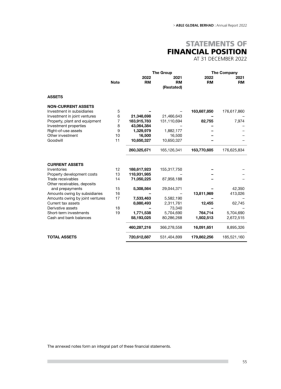

In [6]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# === LOCAL FILE ===
#img = Image.open("report.jpg")  # report.jpg's output has been saved in output/01

# === ONLINE DATASET === # 11th sample's output has been saved in output/02
ds = load_dataset("jinkhye/MyFinMarkdown-sample", split="train[:20]")  
sample = ds[10]  # 11th example, unseen example
img = sample["images"][0]
img = img.convert("RGB") 
print(sample["messages"]) 

plt.imshow(img)
plt.axis('off')

In [7]:
# Markdownify - Markdown Generation
system_prompt = """You are a PDF-to-Markdown converter specialized in financial tables.
Input: raw text extracted from a image, including titles, section headers,
footnotes, and any number of tables with varying column layouts.
Output: ONLY clean Markdown.
"""

user_prompt = """
1. Detect and emit table titles & headers
- Output any standalone title and headers if any preceding the section
containing the table → Markdown header (#).

2. Parse each table
a. Identify the header row (first row containing multiple columns).
b. Extract:
- All year tokens (YYYY).
- Any entity tokens (Group, Company).
- Any measure tokens (Number of shares, Amount, currency codes).
- A “Note” column if present, and an “Item” or description column.
c. Only when “Group”/“Company” information is presented in the header,
include the Group/Company in the parsed header such as: "2023 Group
(CUR’000)".
- For non-“Group/Company” cases, use back the original headers in the
source table.
d. Never transpose the table.

3. Build a canonical header
- Always include a header for all columns.
- Analyse and replace the header with a suitable title ONLY IF the header
is missing.
- Include a Note column after the first description column only if the
source table has one.

4. Render rows
- Detect columns visually — based on vertical alignment, grid lines, or
spacing.
- Split each row cell by column position. Maintain alignment
between headers and data cells—each row must have the exact same number
of cells as the header.
- If a row is shorter than expected, fill missing cells with ’-’. Detect
columns visually — based on vertical alignment, grid lines, or spacing.
- Preserve note numbers in the Note column.
- Negative numbers keep their minus sign or parentheses, but remain
in-cell.

5. Section headers inside tables
- If a row has a single merged label (e.g. “CASH FLOWS FROM FINANCING
ACTIVITIES”), render as:
| CASH FLOWS FROM FINANCING ACTIVITIES |||||

6. Subtotals & Totals
- If a row represents “Total” or “Net”, bold the entire row label and
all its numeric values.

7. No explanations
- Output only the final Markdown containing tables and text.
- Attempt to follow the structure of the source tables as closely as
possible.
- Do not include any commentary, analysis, or non-Markdown text.

<Example1 - missing header on first column>
Source headers:
| Group |
| 2024 CUR’000 |2023 CUR’000 |

Canonical header:
| <Header> | 2024 Group (CUR’000) | 2023 Group (CUR’000) |
*Replace <Header> with a suitable name if missing
</Example1>

<Example2>
Source headers:
| The Group | | The Company | |
| At cost | Note | 2024 CUR’000 |2023 CUR’000 | 2024 CUR’000 |
2023 CUR’000 |

Canonical header:
| At cost | Note | 2024 The Group (CUR’000) | 2023 The Group (CUR’000) |
2024 The Company (CUR’000) | 2023 The Company (CUR’000) |
</Example2>

Return the markdown representation of this document as if you were reading it naturally.
"""

In [8]:
messages = [
    {"role": "system", "content": [{"type":"text", "text": system_prompt}]},
    {"role": "user",   "content": [
        {"type":"image"},
        {"type":"text", "text": user_prompt}
    ]},
]

prompt_text = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=False,           
    return_tensors=None      
)

inputs = processor(
    text=prompt_text,
    images=[[img]],           
    return_tensors="pt",
)

device = next(model.parameters()).device
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=1024, do_sample=False)  # tokens = 1024, may need to increase for complete/complex output

gen_only = out[:, inputs["input_ids"].shape[-1]:]
markdown_pred = processor.tokenizer.decode(gen_only[0], skip_special_tokens=True)

print("=== Generated Markdown ===")
print(markdown_pred)


=== Generated Markdown ===
| ASSETS | The Group | The Company | 2022 RM | 2021 RM | 2022 RM | 2021 RM |
| --- | --- | --- | --- | --- | --- | --- |
| NON-CURRENT ASSETS |  |  |  |  |  |  |
| Investment in subsidiaries | 5 |  | 183,915,783 | 131,110,694 | 82,755 | 7,974 |
| Investment in joint ventures | 6 |  | 21,348,698 | 21,466,643 |  |  |
| Property, plant and equipment | 7 |  | 188,617,923 | 155,317,750 |  |  |
| Investment properties | 8 |  | 43,064,384 |  |  |  |
| Right-of-use assets | 9 |  | 1,329,979 | 1,882,177 |  |  |
| Other investment | 10 |  | 16,500 | 16,500 |  |  |
| Goodwill | 11 |  | 10,650,327 | 10,650,327 |  |  |
|  |  |  | 260,325,671 | 165,126,341 | 163,770,605 | 176,625,834 |
| CURRENT ASSETS |  |  |  |  |  |  |
| Inventories | 12 |  | 118,931,985 |  |  |  |
| Property development costs | 13 |  | 71,050,225 | 87,958,188 |  |  |
| Trade receivables | 14 |  | 5,308,564 | 29,044,371 |  |  |
| Other receivables, deposits and prepayments | 15 |  | 7,533,463 | 5,582,19

In [9]:
with open("./output/02/2.md", "w", encoding="utf-8") as f:
    f.write(markdown_pred)

def markdown_to_csv(md: str) -> str:
    lines = []
    for line in md.splitlines():
        s = line.strip()
        if s.startswith("|") and s.endswith("|") and set(s) != {"|", "-"}:
            cells = [c.strip() for c in s.strip("|").split("|")]
            lines.append(",".join(cells))
    return "\n".join(lines)

csv_pred = markdown_to_csv(markdown_pred)
with open("./output/02/2.csv", "w", encoding="utf-8") as f:
    f.write(csv_pred)
print("Saved: 2.md, 2.csv")

Saved: 2.md, 2.csv


### 1. After Save as actual.csv
- Can use evaluation framework from github - MyFinMarkdown

### 2. Pull Evaluation Framework from Github:
- Follow the coding below:

/ git clone https://github.com/jinkhye/MyFinMarkdown.git

/ cd MyFinMarkdown

/ pip install -r requirements.txt

### 3. Set OpenAI API key

At command prompt: set OPENAI_API_KEY="your_api_key_here"

### 4. Prepare the files

1. Ensure both CSV files have a column named output that contains the raw markdown text for each table.
2. Open run_evaluation.py and update the file paths to point to your specific CSV file (expected_csv_path & actual_csv_path)
3. run "python run_evaluation.py" for evaluation


### Extra: Test on other image

In [ ]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from peft import PeftModel
from PIL import Image
import io, requests

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
lora_dir = "./qwen-vl-mini-1sample"  

bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

base = AutoModelForVision2Seq.from_pretrained(
    model_id, quantization_config=bnb, device_map="auto", torch_dtype=torch.float16
)
model = PeftModel.from_pretrained(base, lora_dir)
processor = AutoProcessor.from_pretrained(model_id)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"}, 
            {"type": "text", "text": "What animal you see?"}
        ]
    }
]

#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"
#img = Image.open(requests.get(url, stream=True, timeout=10).raw).convert("RGB")

In [ ]:
img = Image.open("lion.jpg").convert("RGB")
img = img.resize((192, 192), Image.BICUBIC)

prompt = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = processor(
    text=prompt,
    images=[[img]],                
    return_tensors="pt",
    padding=True
).to(model.device)

with torch.inference_mode():
    gen_ids = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=False
    )
out = processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
print(out)

In [ ]:
img = Image.open("puppy.jpeg").convert("RGB")
img = img.resize((192, 192), Image.BICUBIC)

prompt = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = processor(
    text=prompt,
    images=[[img]],                
    return_tensors="pt",
    padding=True
).to(model.device)

with torch.inference_mode():
    gen_ids = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=False
    )
out = processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
print(out)